# Second look at the challenge <a class="tocSkip">

This challenge is a supervised survival prediction problem: predict the **survival time of a patient** (remaining days to live) from one three-dimensional CT scan (grayscale image) and a set of pre-extracted quantitative imaging features, as well as clinical data.

My first approach to the challenge was a pretty basic one : use only the clinical data and the provided radiomics to train a model and make predictions. This approach did not give good results (score of **0.5182** on the test set) as this was my first time approaching a survival analysis problem but it was nonetheless a very instructive experience. 

After completing the [AI For Medicine Specialization](https://www.coursera.org/specializations/ai-for-medicine), in which a whole course was dedicated to **Medical Prognosis**, I felt like a lot of key concepts (censoring, concordance index, cox proportional hazard ...) went over my head during my first approach at this challenge. As such, I wanted to give this challenge a try for a second time, given I had a better understanding of the task of survival analysis.

For my second approach, I also made sure to improve on the mistakes I had made on my first approach and make use of the imaging modalities.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Exploration</a></span></li><li><span><a href="#Data-Visualization" data-toc-modified-id="Data-Visualization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Visualization</a></span><ul class="toc-item"><li><span><a href="#Features" data-toc-modified-id="Features-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Features</a></span></li><li><span><a href="#Images" data-toc-modified-id="Images-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Images</a></span></li></ul></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature engineering</a></span><ul class="toc-item"><li><span><a href="#Radiomics" data-toc-modified-id="Radiomics-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Radiomics</a></span><ul class="toc-item"><li><span><a href="#Computing-Radiomics" data-toc-modified-id="Computing-Radiomics-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Computing Radiomics</a></span></li><li><span><a href="#Merge-with-the-radiomics-provided" data-toc-modified-id="Merge-with-the-radiomics-provided-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Merge with the radiomics provided</a></span></li></ul></li><li><span><a href="#NaN-Values" data-toc-modified-id="NaN-Values-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>NaN Values</a></span><ul class="toc-item"><li><span><a href="#Radiomics" data-toc-modified-id="Radiomics-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Radiomics</a></span></li><li><span><a href="#Clinical" data-toc-modified-id="Clinical-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Clinical</a></span></li></ul></li><li><span><a href="#Standardization-&amp;-Encoding" data-toc-modified-id="Standardization-&amp;-Encoding-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Standardization &amp; Encoding</a></span></li></ul></li><li><span><a href="#Model-Building" data-toc-modified-id="Model-Building-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Building</a></span><ul class="toc-item"><li><span><a href="#Feature-selection-using-VIF" data-toc-modified-id="Feature-selection-using-VIF-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Feature selection using VIF</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Model</a></span></li></ul></li><li><span><a href="#Applying-on-test-set" data-toc-modified-id="Applying-on-test-set-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Applying on test set</a></span></li><li><span><a href="#Tuning" data-toc-modified-id="Tuning-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Tuning</a></span><ul class="toc-item"><li><span><a href="#Unskew-the-'age'" data-toc-modified-id="Unskew-the-'age'-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Unskew the 'age'</a></span></li><li><span><a href="#Stratification-of-covariates" data-toc-modified-id="Stratification-of-covariates-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Stratification of covariates</a></span><ul class="toc-item"><li><span><a href="#Bins" data-toc-modified-id="Bins-7.2.1"><span class="toc-item-num">7.2.1&nbsp;&nbsp;</span>Bins</a></span></li><li><span><a href="#Predictions" data-toc-modified-id="Predictions-7.2.2"><span class="toc-item-num">7.2.2&nbsp;&nbsp;</span>Predictions</a></span></li></ul></li><li><span><a href="#Penalizer" data-toc-modified-id="Penalizer-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Penalizer</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span><ul class="toc-item"><li><span><a href="#Improvements" data-toc-modified-id="Improvements-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Improvements</a></span></li></ul></li><li><span><a href="#Sources" data-toc-modified-id="Sources-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Sources</a></span></li></ul></div>

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import SimpleITK as sitk

import util

import os
import warnings
warnings.filterwarnings("ignore")

# Data Exploration

In [2]:
def load_data(directory, output = True):
    clinical = pd.read_csv(directory + "/features/clinical_data.csv")
    radiomics = pd.read_csv(directory + "/features/radiomics.csv", skiprows = [0, 2])
    radiomics.columns.values[0] = "PatientID"
    radiomics.set_index("PatientID", inplace = True)
    clinical.set_index("PatientID", inplace = True)
    if output:
        output_df = pd.read_csv(directory + "/output_y_train.csv", index_col="PatientID")
        return clinical, radiomics, output_df
    return clinical, radiomics

In [3]:
train_path = "data/train"
test_path = "data/test"

In [4]:
train_clinical, train_radiomics, train_output = load_data(train_path)

In [5]:
train_radiomics.head()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,
202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,5.138062,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,4.461054,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,3.437111,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,4.352564,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237.0,8.072532e+08,4.055700,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812


# Data Visualization

In this part I first go over some of the features I thought were interesting to examine. Afterward, I have a look at the image modalities provided.

## Features

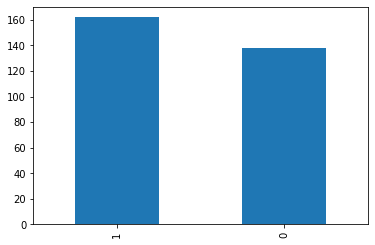

In [29]:
pd.value_counts(train_output["Event"]).plot.bar()
plt.show()

We can see that the proportion of censored and uncensored data is pretty much balanced.

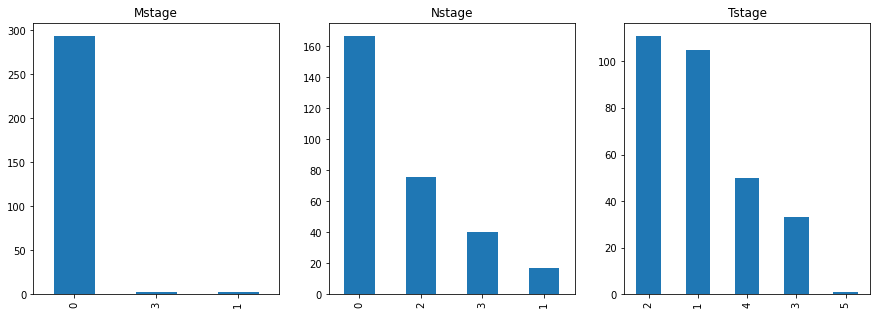

In [37]:
fig, axs = plt.subplots(1, 3, figsize = (15,5))

pd.value_counts(train_clinical["Mstage"]).plot.bar(ax=axs[0], title='Mstage')
pd.value_counts(train_clinical["Nstage"]).plot.bar(ax=axs[1], title='Nstage')
pd.value_counts(train_clinical["Tstage"]).plot.bar(ax=axs[2], title='Tstage')

plt.show()

We can see that for some categorical features, the data is very unbalanced. In my first approach I decided to discard some of them since I thought they accounted for a very low variance but this time I decided to keep them and choose my features differently.

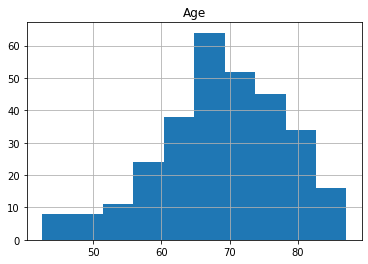

In [169]:
train_clinical.hist(column='age')
plt.title('Age')
plt.show()

I wanted to have a look at the distribution of the *age* feature as I wanted to see whether or not it would be useful to try to unskew the data using a log transformation before scaling later. I thought that might improve the results.

## Images

The images are of shape (92,92,92) so I wanted to have an in-depth look of what the images looked like. They're composed of one scan (what the gif originated from) and a mask that indicates the pixels with a tumor.

<img src="tmp/gif.gif" width="150" align="center">
<p style="text-align: center;"><ins>CT scan of patient 02</ins></p>

In [38]:
archive = np.load('data/train/images/patient_002.npz')
scan = archive['scan']
mask = archive['mask']

In [39]:
img = sitk.GetImageFromArray(scan)
labels = sitk.GetImageFromArray(mask.astype(np.int16))
## Expanding the images just to have a better view of them.
ext_img = sitk.Expand(img,[2,2,2])
ext_labels = sitk.Expand(labels,[2,2,2])
size = ext_img.GetSize()

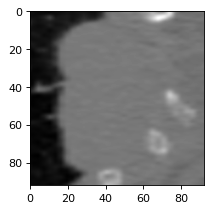

In [40]:
util.myshow(ext_img)

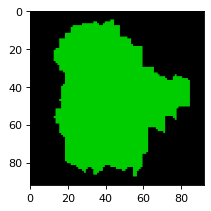

In [41]:
util.myshow(sitk.LabelToRGB(ext_labels))

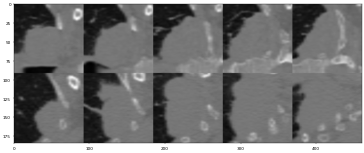

In [42]:
util.myshow3d(ext_img,yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

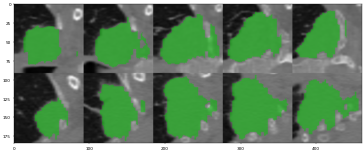

In [44]:
resampled_img_labels = sitk.Resample(ext_labels, ext_img, sitk.Transform(), sitk.sitkNearestNeighbor,
                                     0.0, ext_labels.GetPixelID())
util.myshow3d(sitk.LabelOverlay(sitk.Cast(sitk.RescaleIntensity(ext_img), sitk.sitkUInt8),resampled_img_labels, 0.5),
         yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

# Feature engineering

## Radiomics

To make use of the images I decided to compute the radiomics using the [pyradiomics](https://pyradiomics.readthedocs.io/en/latest/) library.

In [6]:
import six
from radiomics import featureextractor
import logging
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

### Computing Radiomics

In [101]:
def calculate_radiomics(path):
    data = pd.DataFrame()
    empty_patients = []
    img_path = path + "/images"
    imgs_names = os.listdir(img_path)
    for img_name in imgs_names:
        archive = np.load(img_path + "/" + img_name)
        scan = archive['scan']
        mask = archive['mask']
        
        if(np.max(mask) == 1): # Can't compute if the mask is empty
            img = sitk.GetImageFromArray(scan)
            labels = sitk.GetImageFromArray(mask.astype(np.int16))

            extractor = featureextractor.RadiomicsFeatureExtractor()
            result = extractor.execute(img, labels)
            
            result.update({'PatientID':int(img_name[8:11])})
            result.move_to_end('PatientID', last=False)
    
            df = pd.DataFrame([result])
            data = pd.concat([data, df])
        else:
            empty_patients.append(int(img_name[8:11]))
    
    data.set_index("PatientID", inplace = True)
    data = data.reindex(data.index.union(empty_patients))
    data.index.name = "PatientID"
    ## Getting rid of some useless columns
    useful_cols = [col for col in data.columns if (col.startswith('original'))]
    data = data[useful_cols]
    
    return data

In [10]:
data_computed = calculate_radiomics(train_path)
data_computed.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
PatientID,,,,,,,,,,,,,,,,,,,,,
2,0.845935,0.662111,53.515666,80.825884,83.81527307120105,94.82615672903758,91.67878707749138,100.12991560967181,184317.125,68.373418,...,474.18298682293903,0.0014159294924583742,7.440152780881469,0.05065013935430697,811080.0103191268,4.638003576181803,5.446082904968082e-05,1208.990130928983,0.004242342429635777,0.3528600071678195
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.569301,0.297203,30.694000,103.276380,74.0,92.78469701410896,79.64923100695951,131.56367279762298,110062.33333333333,58.795315,...,810.8716535702498,0.0011823588904757247,8.05320738907593,0.12583400659035412,43542.93247932123,1.2453260036682692,0.000216962582959674,2124.6732991252165,0.029745506287594543,0.593370980923771
5,0.657590,0.637447,20.142002,31.597938,37.94733192202055,28.231188426986208,37.94733192202055,39.242833740697165,8212.958333333334,20.778485,...,512.0107957465933,0.006010770464847511,6.445624212509823,0.03442424242424243,78052.2017952787,0.3192361746468855,0.0011584858008878434,493.9439694152586,0.004182293302986566,7.9263924028377275
7,0.781861,0.714780,57.322521,80.196007,87.66413177577246,91.0659101969557,97.49358953285082,97.67804256842989,190077.83333333334,62.702117,...,599.6044641863026,0.0010591164492006718,7.968079701923623,0.05924262819164598,611132.025210262,3.6014025715567675,5.676665846302051e-05,1723.9199416906906,0.009181368148031591,0.5111257271308385


We can see that data is missing for some patients. This is due to the fact that some patients had empty masks (full of 0) and so we can't compute the radiomics for them.

### Merge with the radiomics provided

In [14]:
data_computed.shape

(300, 107)

In [15]:
train_radiomics.shape

(300, 53)

We get almost 2 times more radiomics features.  
Since we computed all the radiomics features, we're bound to have some computed features that are also in the provided dataset. I could :
1. Keep them both but the colinearity between those two is probably very high so I avoided that solution.
2. Keep only the provided one.
3. Keep only the computed one but some of the rows are missing values.
4. Keep only the computed one but for rows with missing data (couldn't compute due to an empty mask) fill in with the provided value.

I decided to go with the 4th solution as it allows us to make full use, when possible, of the computed radiomics.

In [45]:
def merge(computed, original):
    computed_cols = list(computed.columns)
    original_cols = list(original.columns)
    for column in computed_cols:
        if column in original_cols:
            missing_rows = computed.index[computed[column].isnull()].tolist()
            computed[column][missing_rows] = original[column][missing_rows]
            original_cols.remove(column)
    # Some of the provided features were not computed so we add them to the merged dataset
    if(len(original_cols) != 0):
        data = pd.concat([computed, original[original_cols]], axis=1)
    else:
        data = computed
    return data

In [12]:
data = merge(data_computed, train_radiomics)
data.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,original_shape_Compactness1,original_shape_Compactness2,original_shape_SphericalDisproportion,original_firstorder_StandardDeviation
PatientID,,,,,,,,,,,,,,,,,,,,,
2,0.845935,0.662111,53.515666,80.825884,83.81527307120105,94.82615672903758,91.67878707749138,100.12991560967181,184317.125,68.373418,...,811080.0103191268,4.638003576181803,5.446082904968082e-05,1208.990130928983,0.004242342429635777,0.3528600071678195,0.024239,0.208753,1.685735,99.296601
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178.118,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.014520,0.074913,2.372178,234.770396
4,0.569301,0.297203,30.694000,103.276380,74.0,92.78469701410896,79.64923100695951,131.56367279762298,110062.33333333333,58.795315,...,43542.93247932123,1.2453260036682692,0.000216962582959674,2124.6732991252165,0.029745506287594543,0.593370980923771,0.022972,0.187502,1.747154,222.740062
5,0.657590,0.637447,20.142002,31.597938,37.94733192202055,28.231188426986208,37.94733192202055,39.242833740697165,8212.958333333334,20.778485,...,78052.2017952787,0.3192361746468855,0.0011584858008878434,493.9439694152586,0.004182293302986566,7.9263924028377275,0.030597,0.332627,1.443269,74.859566
7,0.781861,0.714780,57.322521,80.196007,87.66413177577246,91.0659101969557,97.49358953285082,97.67804256842989,190077.83333333334,62.702117,...,611132.025210262,3.6014025715567675,5.676665846302051e-05,1723.9199416906906,0.009181368148031591,0.5111257271308385,0.024970,0.221540,1.652657,140.531957


In [17]:
data.shape

(300, 111)

We end up with 111 radiomics features.

## NaN Values

### Radiomics

For the numerical features (radiomics and age) I went with a pretty basic approach by replacing missing values with the mean of the feature.

I also stored the computed data in a csv for convenience.

In [25]:
new_train_radiomics = data.apply(lambda x: x.fillna(x.mean()),axis=0)
del data

In [47]:
## new_train_radiomics.to_csv('new_train_radiomics.csv')
new_train_radiomics = pd.read_csv("new_train_radiomics.csv", index_col='PatientID')
print(new_train_radiomics.shape)
new_train_radiomics.head()

(300, 111)


,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,original_shape_Compactness1,original_shape_Compactness2,original_shape_SphericalDisproportion,original_firstorder_StandardDeviation
PatientID,,,,,,,,,,,,,,,,,,,,,
2,0.845935,0.662111,53.515666,80.825884,83.815273,94.826157,91.678787,100.129916,184317.125000,68.373418,...,811080.010319,4.638004,0.000054,1208.990131,0.004242,0.352860,0.024239,0.208753,1.685735,99.296601
3,0.764616,0.597634,28.271001,48.924539,53.351820,51.361764,53.820359,178.117938,54761.826130,36.383590,...,156289.798741,1.409005,0.001883,2399.445952,0.169972,2.102808,0.014520,0.074913,2.372178,234.770396
4,0.569301,0.297203,30.694000,103.276380,74.000000,92.784697,79.649231,131.563673,110062.333333,58.795315,...,43542.932479,1.245326,0.000217,2124.673299,0.029746,0.593371,0.022972,0.187502,1.747154,222.740062
5,0.657590,0.637447,20.142002,31.597938,37.947332,28.231188,37.947332,39.242834,8212.958333,20.778485,...,78052.201795,0.319236,0.001158,493.943969,0.004182,7.926392,0.030597,0.332627,1.443269,74.859566
7,0.781861,0.714780,57.322521,80.196007,87.664132,91.065910,97.493590,97.678043,190077.833333,62.702117,...,611132.025210,3.601403,0.000057,1723.919942,0.009181,0.511126,0.024970,0.221540,1.652657,140.531957


### Clinical

In [48]:
train_clinical.isnull().sum(axis = 0)

Histology        20
Mstage            0
Nstage            0
SourceDataset     0
Tstage            0
age              16
dtype: int64

In [49]:
print(train_clinical['Histology'].value_counts())

Adenocarcinoma                         80
large cell                             61
squamous cell carcinoma                59
nos                                    38
adenocarcinoma                         21
Squamous cell carcinoma                19
NSCLC NOS (not otherwise specified)     2
Name: Histology, dtype: int64


For the Histology feature, we can see that some features appear multiple times but with a change in the syntax. I unified them and replaced the missing values with the **'nos'** category — `Not Otherwise Specified.`

In [50]:
train_clinical['Histology'][train_clinical['Histology'] == 'adenocarcinoma'] = 'Adenocarcinoma'
train_clinical['Histology'][train_clinical['Histology'] == 'squamous cell carcinoma'] = 'Squamous cell carcinoma'
train_clinical['Histology'][train_clinical['Histology'] == 'NSCLC NOS (not otherwise specified)'] = 'nos'
train_clinical['Histology'].fillna('nos', inplace=True)
train_clinical["age"].fillna(train_clinical["age"].mean(), inplace=True)

## Standardization & Encoding

In [51]:
print(train_clinical.isnull().values.any())
print(train_output.isnull().values.any())
print(new_train_radiomics.isnull().values.any())

False
False
False


In [52]:
train_df = new_train_radiomics.join([train_clinical, train_output])
print(train_df.shape)
train_df.head()

(300, 119)


,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_shape_SphericalDisproportion,original_firstorder_StandardDeviation,Histology,Mstage,Nstage,SourceDataset,Tstage,age,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,
2,0.845935,0.662111,53.515666,80.825884,83.815273,94.826157,91.678787,100.129916,184317.125000,68.373418,...,1.685735,99.296601,Adenocarcinoma,0,0,l1,3,59.4223,638,0
3,0.764616,0.597634,28.271001,48.924539,53.351820,51.361764,53.820359,178.117938,54761.826130,36.383590,...,2.372178,234.770396,Squamous cell carcinoma,0,3,l1,1,77.0986,421,0
4,0.569301,0.297203,30.694000,103.276380,74.000000,92.784697,79.649231,131.563673,110062.333333,58.795315,...,1.747154,222.740062,Squamous cell carcinoma,0,0,l1,3,84.5722,465,1
5,0.657590,0.637447,20.142002,31.597938,37.947332,28.231188,37.947332,39.242834,8212.958333,20.778485,...,1.443269,74.859566,nos,0,0,l1,2,71.8439,1295,1
7,0.781861,0.714780,57.322521,80.196007,87.664132,91.065910,97.493590,97.678043,190077.833333,62.702117,...,1.652657,140.531957,Squamous cell carcinoma,0,0,l1,4,60.7283,1393,0


The last step to get a dataset ready for our model is to encode the non-numerical features and standardize the numerical ones. Here's our last steps :

- Scale numerical features
- One-hot encode Histology feature
- Label encode the rest of the categorical features

In [53]:
one_hot_features = ['Histology']
label_features = ['Mstage', 'SourceDataset', 'Tstage']
N_feature = ['Nstage']
numerical_features = list(new_train_radiomics) + ['age']

In [54]:
train_df = pd.get_dummies(train_df, columns=one_hot_features, drop_first=True)

I had to make a particular OrdinalEncoder just for the Nstage feature because one of the values would only appear in the test set so I had to specify all the possible values in a new encoder.

In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder


ct = ColumnTransformer([
        ('scaling_numerical', StandardScaler(), numerical_features),
        ('labeling_categorical', OrdinalEncoder(), label_features),
        ('labeling_N', OrdinalEncoder(categories=[[0,1,2,3,4]]), N_feature)
])

train_transformed = pd.DataFrame(ct.fit_transform(train_df[numerical_features + label_features + N_feature]), columns=numerical_features + label_features + N_feature, index=train_df.index)
train_df[numerical_features + label_features + N_feature] = train_transformed

# Model Building

## Feature selection using VIF

In [56]:
train_df.shape

(300, 121)

Now that we're done processing our dataset we end up with 121 features. Before making any type of selection between the features I tried to run the model on all of them but the high-collinearity between the radiomics features led to an error with the convergence of our model. One of the solution they suggest (see [here](https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model)) is to **use VIF to find redundant variables**, which is what I did.

In [57]:
# Taken from https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [58]:
transformer = ReduceVIF()
X = transformer.fit_transform(train_df[list(set(train_df.columns) - set(['SurvivalTime']))], train_df['SurvivalTime'])
X.head()

ReduceVIF fit
ReduceVIF transform
Dropping original_firstorder_Maximum with vif=inf
Dropping original_glszm_ZoneVariance with vif=63751722.31650127
Dropping original_firstorder_Energy with vif=7395272.205290849
Dropping original_glcm_Id with vif=1494067.663164341
Dropping original_glcm_SumSquares with vif=237561.73527484882
Dropping original_glrlm_RunPercentage with vif=50447.75336812867
Dropping original_glrlm_LowGrayLevelRunEmphasis with vif=33880.39205722408
Dropping original_glrlm_LongRunEmphasis with vif=26997.586111135734
Dropping original_glcm_SumAverage with vif=23829.674156740755
Dropping original_glcm_Idm with vif=17746.4137190732
Dropping original_glrlm_HighGrayLevelRunEmphasis with vif=13091.985972014005
Dropping original_firstorder_Entropy with vif=12103.892431159991
Dropping original_gldm_SmallDependenceEmphasis with vif=8854.45890067188
Dropping original_glcm_JointEntropy with vif=8647.47812152606
Dropping original_glrlm_ShortRunLowGrayLevelEmphasis with vif=6916.9396277

,Histology_nos,original_firstorder_90Percentile,Histology_large cell,original_shape_Flatness,original_ngtdm_Coarseness,original_glcm_Imc2,Histology_Squamous cell carcinoma,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_ngtdm_Strength,original_shape_SphericalDisproportion,...,SourceDataset,original_shape_Elongation,original_glrlm_RunVariance,Event,Nstage,original_glcm_ClusterShade,original_firstorder_Range,Mstage,original_firstorder_Minimum,original_glszm_GrayLevelNonUniformityNormalized
0,0.0,0.230332,0.0,0.458284,-5.796585e-01,-1.207264,0.0,-1.273317e-01,-0.469878,0.058710,...,0.0,5.975771e-01,5.249967e-01,0.0,0.0,0.564507,0.487931,0.0,0.655254,5.490642e-02
1,0.0,0.000000,0.0,0.000000,6.872750e-17,0.141746,1.0,2.032391e-16,0.000000,2.196868,...,0.0,-8.158520e-16,1.608741e-16,0.0,3.0,0.182486,-0.577637,0.0,-0.875539,7.767352e-16
2,0.0,4.525977,0.0,-2.135381,-5.281536e-01,1.249297,1.0,-1.708327e-01,-0.405299,0.250020,...,0.0,-1.435279e+00,-8.366114e-02,1.0,0.0,0.625265,0.984574,0.0,1.056620,-1.329966e+00
3,1.0,0.657052,0.0,0.282980,-2.297381e-01,-1.432317,0.0,-7.153816e-02,1.563690,-0.696534,...,0.0,-7.864821e-01,1.550645e+00,1.0,0.0,0.560977,-0.694220,0.0,0.711258,1.221797e+00
4,0.0,0.144988,0.0,0.832645,-5.789276e-01,0.206439,1.0,-1.450603e-01,-0.427382,-0.044323,...,0.0,1.267279e-01,6.179524e-01,0.0,0.0,-0.024894,1.185097,0.0,-0.156813,-7.276453e-01


In [61]:
features_vifed = list(X.columns) + ['SurvivalTime']
features_vifed

['Histology_nos',
 'original_firstorder_90Percentile',
 'Histology_large cell',
 'original_shape_Flatness',
 'original_ngtdm_Coarseness',
 'original_glcm_Imc2',
 'Histology_Squamous cell carcinoma',
 'original_gldm_LargeDependenceLowGrayLevelEmphasis',
 'original_ngtdm_Strength',
 'original_shape_SphericalDisproportion',
 'original_firstorder_TotalEnergy',
 'age',
 'original_firstorder_Kurtosis',
 'original_glcm_MCC',
 'Tstage',
 'original_ngtdm_Complexity',
 'original_glszm_LargeAreaHighGrayLevelEmphasis',
 'original_ngtdm_Busyness',
 'original_glszm_SmallAreaLowGrayLevelEmphasis',
 'SourceDataset',
 'original_shape_Elongation',
 'original_glrlm_RunVariance',
 'Event',
 'Nstage',
 'original_glcm_ClusterShade',
 'original_firstorder_Range',
 'Mstage',
 'original_firstorder_Minimum',
 'original_glszm_GrayLevelNonUniformityNormalized',
 'SurvivalTime']

We can see there were a lot of variables with high colinearity. We went from 121 features to 30.

We're now ready to train our model.

## Model

In [62]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(train_df[features_vifed], duration_col = 'SurvivalTime', event_col='Event')
cph.print_summary()

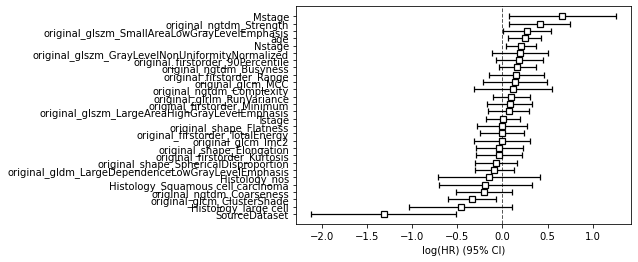

In [63]:
cph.plot()

In [64]:
cph.score_

0.7260390966027709

In [65]:
from lifelines.utils import k_fold_cross_validation
cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, train_df[features_vifed], duration_col='SurvivalTime', event_col='Event', k=5)
print(scores)
print(f'C-Index mean : {np.mean(scores)}')

[0.6425567703952901, 0.6737704918032786, 0.6697819314641744, 0.693783576362241, 0.6175298804780877]
C-Index mean : 0.6594845301006144


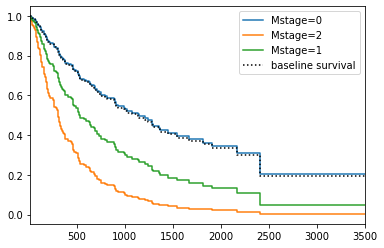

In [75]:
cph.plot_covariate_groups('Mstage', values=[0.0, 2.0, 1.0])

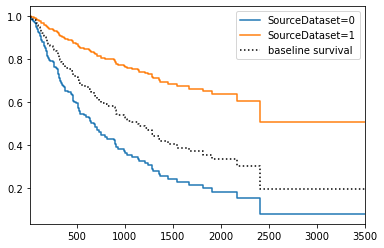

In [72]:
cph.plot_covariate_groups('SourceDataset', values=[0.0, 1.0])

The first model achieves **0.7260** concordance score on the training data.

It's very interesting to see how impactful the **Mstage** feature and **SourceDataset** features are on the survival risk, both of which I discarded during my first approach. Whilst it's logical that a higher cancer stage would reduce the chance of survival, it's interesting to see that being from the **'L1'** dataset also dwindles your chances of survival. This hints to a disparity of survival between the two datasets.

# Applying on test set

In [77]:
test_clinical, test_radiomics = load_data(test_path, output=False)

In [105]:
test_computed_radiomics = calculate_radiomics(test_path)
test_data = merge(test_computed_radiomics, test_radiomics)
new_test_radiomics = test_data.apply(lambda x: x.fillna(x.mean()),axis=0)
del test_data
## new_test_radiomics.to_csv('new_test_radiomics.csv')

In [78]:
new_test_radiomics = pd.read_csv("new_test_radiomics.csv", index_col='PatientID')
test_clinical['Histology'][test_clinical['Histology'] == 'adenocarcinoma'] = 'Adenocarcinoma'
test_clinical['Histology'][test_clinical['Histology'] == 'squamous cell carcinoma'] = 'Squamous cell carcinoma'
test_clinical['Histology'][test_clinical['Histology'] == 'NSCLC NOS (not otherwise specified)'] = 'nos'
test_clinical['Histology'].fillna('nos', inplace=True)
test_clinical["age"].fillna(test_clinical["age"].mean(), inplace=True)

In [79]:
test_df = new_test_radiomics.join([test_clinical])
test_df = pd.get_dummies(test_df, columns=one_hot_features, drop_first=True)

In [80]:
X_test = pd.DataFrame(ct.transform(test_df[numerical_features + label_features + N_feature]), columns=numerical_features+label_features+N_feature, index=test_df.index)
test_df[numerical_features + label_features + N_feature] = X_test

In [81]:
pred_features = list(set(features_vifed) - set(['SurvivalTime', 'Event']))
prediction_result = cph.predict_expectation(test_df[pred_features])
prediction_result["Event"] = "nan"
prediction_result

,0,Event
0,2762.938807,nan
1,1001.560075,nan
6,814.000228,nan
9,3170.370431,nan
10,255.934947,nan
...,...,...
411,1450.590253,nan
412,2058.491436,nan
413,1796.444505,nan
415,1231.215236,nan


In [82]:
random = pd.read_csv("random_submission_0vhlEZN.csv")
order_index = list(random['PatientID'].values)
prediction_result = prediction_result.reindex(order_index)
prediction_result.reset_index(level=0, inplace=True)
prediction_result.columns = ['PatientID', 'SurvivalTime', 'Event']
prediction_result

,PatientID,SurvivalTime,Event
0,13,1200.596294,nan
1,155,1283.932130,nan
2,404,1704.086917,nan
3,407,1379.295794,nan
4,9,3170.370431,nan
...,...,...,...
120,66,388.548736,nan
121,132,951.189787,nan
122,169,2680.059743,nan
123,199,1302.103823,nan


In [83]:
prediction_result.to_csv(r'./predictions.csv', index = None, header=True)

With this model we obtain a score of **0.7119** on the test set.

# Tuning

I had multiple ideas to improve our model :
1. Try to **unskew the 'age'** feature using a logarithmic transformation.
2. **Stratification** of covariates that do not obey the proportional hazard assumption.
3. Adding a **penalizer**.

## Unskew the 'age'

I just applied a logarithmic transformation to the 'age' column before the standardization step and re-run the model. We obtain a score of **0.6819** on the test set so this wasn't successful.

## Stratification of covariates

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'original_glcm_ClusterShade' failed the non-proportional test: p-value is 0.0059.

   Advice 1: the functional form of the variable 'original_glcm_ClusterShade' might be incorrect.
That is, there may be non-linear terms missing. The proportional hazard test used is very sensitive
to incorrect functional forms. See documentation in link [D] below on how to specify a functional
form.

   Advice 2: try binning the variable 'original_glcm_ClusterShade' using pd.cut, and then specify it
in `strata=['original_glcm_ClusterShade', ...]` in the call in `.fit`. See documentation in link [B]
below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs

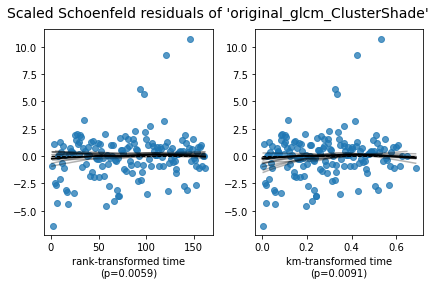

In [30]:
cph.check_assumptions(train_df[features_vifed], p_value_threshold=0.05, show_plots=True)

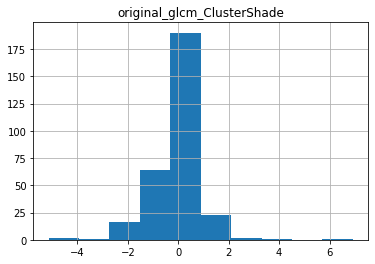

In [71]:
train_df.hist(column='original_glcm_ClusterShade')
plt.title('original_glcm_ClusterShade')
plt.show()

The first solution they offer (see [here](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html)) is to modify the functional form but I wasn't able to pass on a formula in the model so I applied the second solution which is to bin the variable and then to stratify.

### Bins

To choose the size of the bins I tested multiple ones and took the one that gave the best results on the train set.

In [84]:
scores = []
for i in range(2,50):
    train_df_strata = train_df[features_vifed].copy()
    train_df_strata['ClusterShade_strata'] = pd.cut(train_df_strata['original_glcm_ClusterShade'], i)
    train_df_strata = train_df_strata.drop('original_glcm_ClusterShade', axis=1)
    cph = CoxPHFitter()
    cph.fit(train_df_strata, 'SurvivalTime', 'Event', strata=['ClusterShade_strata'])
    if(cph.score_ > 0.71):
        scores.append((i, cph.score_))

In [85]:
scores

[(3, 0.714891846921797), (5, 0.7198311767645915), (7, 0.7197315819531697)]

Looks like 5 bins is the best.

In [210]:
train_df_strata = train_df[features_vifed].copy()
train_df_strata['ClusterShade_strata'], train_bins = pd.cut(train_df_strata['original_glcm_ClusterShade'], 5, retbins=True)
train_df_strata = train_df_strata.drop('original_glcm_ClusterShade', axis=1)

In [211]:
train_df_strata['ClusterShade_strata'].value_counts()

(-0.317, 2.097]     213
(-2.731, -0.317]     80
(2.097, 4.511]        3
(-5.158, -2.731]      3
(4.511, 6.925]        1
Name: ClusterShade_strata, dtype: int64

In [212]:
cph = CoxPHFitter()
cph.fit(train_df_strata, 'SurvivalTime', 'Event', strata=['ClusterShade_strata'])
cph.print_summary()
print(cph.score_)

0.7198311767645915


In [213]:
cph.check_assumptions(train_df_strata)

Proportional hazard assumption looks okay.


### Predictions

In [218]:
pred_features = list(set(features_vifed) - set(['SurvivalTime', 'Event']))
test_df_strata = test_df[pred_features].copy()
test_df_strata['ClusterShade_strata'] = pd.cut(test_df_strata['original_glcm_ClusterShade'], bins=train_bins)
test_df_strata = test_df_strata.drop('original_glcm_ClusterShade', axis=1)

In [219]:
test_df_strata['ClusterShade_strata'].value_counts()

(-0.317, 2.097]     88
(-2.731, -0.317]    36
(-5.158, -2.731]     1
(4.511, 6.925]       0
(2.097, 4.511]       0
Name: ClusterShade_strata, dtype: int64

In [220]:
prediction_result = cph.predict_expectation(test_df_strata)
prediction_result["Event"] = "nan"
prediction_result

,0,Event
0,2547.506479,nan
1,806.127564,nan
6,782.200265,nan
9,3166.751598,nan
10,359.105228,nan
...,...,...
411,1979.851807,nan
412,2832.817247,nan
413,1752.476100,nan
415,809.879489,nan


In [221]:
random = pd.read_csv("random_submission_0vhlEZN.csv")
order_index = list(random['PatientID'].values)
prediction_result = prediction_result.reindex(order_index)
prediction_result.reset_index(level=0, inplace=True)
prediction_result.columns = ['PatientID', 'SurvivalTime', 'Event']
prediction_result

,PatientID,SurvivalTime,Event
0,13,1264.756066,nan
1,155,1586.116867,nan
2,404,1431.465369,nan
3,407,1390.717723,nan
4,9,3166.751598,nan
...,...,...,...
120,66,427.937894,nan
121,132,814.503132,nan
122,169,2507.800378,nan
123,199,724.405465,nan


In [222]:
prediction_result.to_csv(r'./predictions.csv', index = None, header=True)

With this model we obtain a score of **0.7041** on the test set so this wasn't successful either.

## Penalizer

I tried different penalizers and chose the one that gave the best concordance (didn't need GridSearch since it was only one parameter I tried to tune).

In [231]:
penalizers = [0.001, 0.1, 0.2, 0.5, 1.0, 10.0, 15.0, 20.0]
scores = []
for pen in penalizers:
    cph = CoxPHFitter(penalizer=pen)
    cph.fit(train_df[features_vifed], duration_col = 'SurvivalTime', event_col='Event')
    scores.append((pen, cph.score_))
scores

[(0.001, 0.7260390966027709),
 (0.1, 0.726007465047131),
 (0.2, 0.7259758334914911),
 (0.5, 0.7261023597140507),
 (1.0, 0.7264186752704498),
 (10.0, 0.7274625166065667),
 (15.0, 0.7282849370532043),
 (20.0, 0.7279369899411653)]

I found that the best penalizer was **15.0**.

In [244]:
cph = CoxPHFitter(penalizer=15.0)
cph.fit(train_df[features_vifed], duration_col = 'SurvivalTime', event_col='Event')
cph.print_summary()

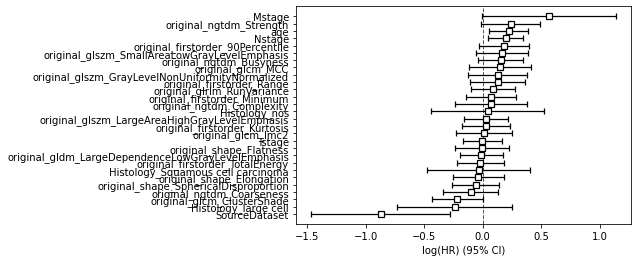

In [245]:
cph.plot()

In [246]:
cph.score_

0.7282849370532043

We can see there's a small improvement in the score on the train set (**0.7260** -> **0.7283**).

With this model we obtain a score of **0.7212** on the test set which is the highest I obtained.

# Conclusion

Through this new approach I was able to make use of the image modalities and obtain much better results than my first approach at this challenge. The model that performed the best was the `Cox Proportional Model with a penalizer of 15.0.`

## Improvements

Other ideas I wanted to try include :

- Using a CNN to generate new features.
- Test [DeepSurv](https://github.com/jaredleekatzman/DeepSurv) model.

# Sources

All the ressources I used during this approach.

- [SimpleITK to handle the images](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/)
- [SimpleITK functions to visualize the images](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/10_matplotlib's_imshow.html)
- [Pyradiomics](https://pyradiomics.readthedocs.io/en/v1.0/usage.html#example)
- [Pyradiomics example to compute radiomics](https://github.com/Radiomics/pyradiomics/blob/master/notebooks/PyRadiomicsExample.ipynb)
- [Convergence Problem (VIF advice)](https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model)
- [VIF Class](https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class)
- [Cox Documentation](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html)
- [Cox & Proportional Hazard Assumption (how to bin & stratify)](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html)
